In [59]:
# Manipulação de dados
import numpy as np
import pandas as pd

# Modelos de classificação
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# (Exemplo de Heterogeneous Boosting com Gradient Boosting)
from sklearn.ensemble import GradientBoostingClassifier

# Validação cruzada e avaliação
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from scipy import stats
from sklearn.metrics import precision_score, recall_score


# Pré-processamento
from sklearn.preprocessing import MinMaxScaler

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Criação do Heterogeneous Boosting
from sklearn.utils import resample
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import mode
from collections import Counter

from tqdm import tqdm

from scipy.stats import t


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier as KNN
# import dumb classifier
from sklearn.dummy import DummyClassifier


In [60]:
def train_and_evaluate_model(model, X, y):
    important_features = []
    model_name = model

    if model == "DT":
        model = DecisionTreeClassifier(random_state=13)
        param_grid = {
            'criterion': ['gini', 'entropy'],
            'max_depth': [5, 10, 15, 25]
        }
    elif model == "KNN":
        model = KNeighborsClassifier()
        param_grid = {
            'n_neighbors':[1,3,5,7,9]
        }
    elif model == "MLP":
        model = MLPClassifier(random_state=13, max_iter=1000)
        param_grid = {
            'hidden_layer_sizes': [(100,),(10,)],
            'alpha': [0.0001, 0.005],
            'learning_rate': ['constant','adaptive']
        }
    elif model == "RF":
        model = RandomForestClassifier(random_state=13)
        param_grid = {
            'n_estimators': [5, 10, 15, 25],
            'max_depth': [10, None]
        }
    else:
        raise ValueError(f"Modelo '{model}' não reconhecido.")

    outer_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36854321)
    scores = []
    precision_scores = []
    recall_scores = []

    for train_idx, test_idx in tqdm(outer_cv.split(X, y), total=outer_cv.get_n_splits(), desc=f"Validando {model.__class__.__name__}"):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        inner_cv = StratifiedKFold(n_splits=4)
        grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        if model_name != "KNN" and model_name != "MLP":
            importances = best_model.feature_importances_
            for fname, importance in zip(X.columns, importances):
                important_features.append({
                'Modelo': model_name,
                'Feature': fname,
                'Importância': importance
                })

        precision_scores.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted', zero_division=0))
        scores.append(acc)

    return scores, precision_scores, recall_scores, important_features

In [61]:
def t_corrigido_nadeau_bengio(data1, data2, X, n_folds_externos):
    """
    Parâmetros:
    data1, data2: listas ou arrays com as acurácias

    X: conjunto de dados original
    n_folds_externos: número de folds no loop externo
    Retorna:
    t_stat: valor da estatística t
    p_valor: valor-p do teste bilateral
    """
    N = len(X) # número total de amostras no dataset
    n = len(data1) # número de execuções
    # Tamanhos dos conjuntos de treino/teste em cada fold externo
    n_test = N // n_folds_externos
    n_train = N - n_test
    # Cálculo da estatística t com correção
    diffs = np.array(data1) - np.array(data2)
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs, ddof=1)
    se_corrigido = std_diff * np.sqrt(1/n + n_test/n_train)
    t_stat = mean_diff / se_corrigido
    p_valor = 2 * (1 - t.cdf(abs(t_stat), df=n - 1))
    return t_stat, p_valor

In [62]:
# 1. Carregar e printar os dados
df = pd.read_csv('KaggleV2-May-2016.csv')
df

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572134e+12,5651768,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3.596266e+12,5650093,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,1.557663e+13,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,9.213493e+13,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No


In [63]:
# Removendo as colunas que não são necessárias para o modelo
cols_to_drop = ['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay']
df.drop(cols_to_drop, axis=1, inplace=True)
df

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...
110522,F,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,F,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,F,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,F,38,MARIA ORTIZ,0,0,0,0,0,1,No


In [64]:
# Corrigir target: transformar 'No-show' em 0 = compareceu, 1 = não compareceu
df['No-show'] = df['No-show'].map({'No': 0, 'Yes': 1})

# Remover instâncias com Handcap (deficiência) diferente de 0 ou 1
df = df[df['Handcap'].isin([0, 1])]

print(df['Handcap'].value_counts())

Handcap
0    108286
1      2042
Name: count, dtype: int64


In [65]:
# Balancear o dataset usando undersampling da classe majoritária
count_class_0, count_class_1 = df['No-show'].value_counts()
df_class_0 = df[df['No-show'] == 0]
df_class_1 = df[df['No-show'] == 1]

df_class_0_under = df_class_0.sample(count_class_1, random_state=42)
df = pd.concat([df_class_0_under, df_class_1], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

#p print no_show distribution
print(df['No-show'].value_counts())

No-show
1    22278
0    22278
Name: count, dtype: int64


In [66]:
# Transformar colunas categóricas em numéricas
le = LabelEncoder()
df['Neighbourhood'] = le.fit_transform(df['Neighbourhood'])
df['Gender'] = le.fit_transform(df['Gender'])
df

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,1,11,66,0,0,0,0,0,0,1
1,0,8,43,0,0,0,0,0,0,0
2,1,14,16,0,0,0,0,0,0,0
3,0,18,15,0,0,0,0,0,1,0
4,1,73,76,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
44551,1,41,38,0,0,0,0,0,0,0
44552,0,32,36,0,0,0,0,0,0,0
44553,1,36,38,0,0,0,0,0,0,1
44554,0,55,14,0,1,0,0,0,0,0


In [67]:


# Normalizar colunas numéricas
scaler = MinMaxScaler()
num_cols = ['Age', 'Neighbourhood']
df[num_cols] = scaler.fit_transform(df[num_cols])

df

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,1,0.095652,0.8250,0,0,0,0,0,0,1
1,0,0.069565,0.5375,0,0,0,0,0,0,0
2,1,0.121739,0.2000,0,0,0,0,0,0,0
3,0,0.156522,0.1875,0,0,0,0,0,1,0
4,1,0.634783,0.9500,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
44551,1,0.356522,0.4750,0,0,0,0,0,0,0
44552,0,0.278261,0.4500,0,0,0,0,0,0,0
44553,1,0.313043,0.4750,0,0,0,0,0,0,1
44554,0,0.478261,0.1750,0,1,0,0,0,0,0


In [68]:
# 3. Separar X e y
X = df.drop('No-show', axis=1)
y = df['No-show']

In [ ]:
# Treinando e avaliando modelos
results = {}
precisions = {}
recalls = {}
features = {}
models = ["DT", "KNN", "MLP", "RF"]
for model in models:
    print(f"Treinando e avaliando modelo: {model}")
    scores,p, r, features = train_and_evaluate_model(model, X, y)
    results[model] = scores
    precisions[model] = p
    recalls[model] = r
    # Criar o DataFrame com todas as importâncias coletadas
    df_features = pd.DataFrame(features)

    # Agrupar por modelo e nome da feature, calcular média
    if model != "KNN" and model != "MLP":
        df_mean_importances = (
            df_features
            .groupby(['Modelo', 'Feature'], as_index=False)
            .agg({'Importância': 'mean'})
            .sort_values(by=['Modelo', 'Importância'], ascending=[True, False])
        )

        

    print(f"Resultados (Acurácia) para {model}: {np.mean(scores)*100:.2f}%")
    print(f"Precision média para {model}: {np.mean(precisions[model]):.2f}")
    print(f"Recall médio para {model}: {np.mean(recalls[model]):.2f}")
    print(f"F1-score médio para {model}: {2 * (np.mean(precisions[model]) * np.mean(recalls[model])) / (np.mean(precisions[model]) + np.mean(recalls[model])):.2f}\n")
    if model != "KNN" and model != "MLP":
        print(f"\nTop features médias para o modelo {model}:")
        print(df_mean_importances[df_mean_importances['Modelo'] == model].head(5))


Treinando e avaliando modelo: DT


Validando DecisionTreeClassifier: 100%|██████████| 30/30 [00:12<00:00,  2.36it/s]

Resultados (Acurácia) para DT: 57.41%
Precision média para DT: 0.58
Recall médio para DT: 0.57
F1-score médio para DT: 0.58


Top features médias para o modelo DT:
  Modelo        Feature  Importância
7     DT   SMS_received     0.505291
0     DT            Age     0.327287
6     DT  Neighbourhood     0.104106
8     DT    Scholarship     0.017571
3     DT         Gender     0.012612


In [70]:
def calcular_ic95(scores):
    mean = np.mean(scores)
    std = np.std(scores, ddof=1)
    n = len(scores)
    conf = 0.95
    h = t.ppf((1 + conf) / 2, df=n - 1) * std / np.sqrt(n)
    return mean, std, mean - h, mean + h

tabela = []

for metodo, scores in results.items():
    media, desvio, inf, sup = calcular_ic95(scores)
    tabela.append([metodo, round(media, 3), round(desvio, 3), round(inf, 3), round(sup, 3), round(np.mean(precisions[metodo]),3), round(np.mean(recalls[metodo]),3), round(2 * (np.mean(precisions[metodo]) * np.mean(recalls[metodo])) / (np.mean(precisions[metodo]) + np.mean(recalls[metodo])),3)])
df_tabela = pd.DataFrame(tabela, columns=['Método', 'Média', 'Desvio Padrão', 'IC 95% Inferior', 'IC 95% Superior', "Precisão", "Recall", "F1-score"])
df_tabela.set_index('Método', inplace=True)
df_tabela.index.name = None  # Remove o nome do índice
display(df_tabela)

,Média,Desvio Padrão,IC 95% Inferior,IC 95% Superior,Precisão,Recall,F1-score
DT,0.574,0.007,0.572,0.577,0.576,0.574,0.575


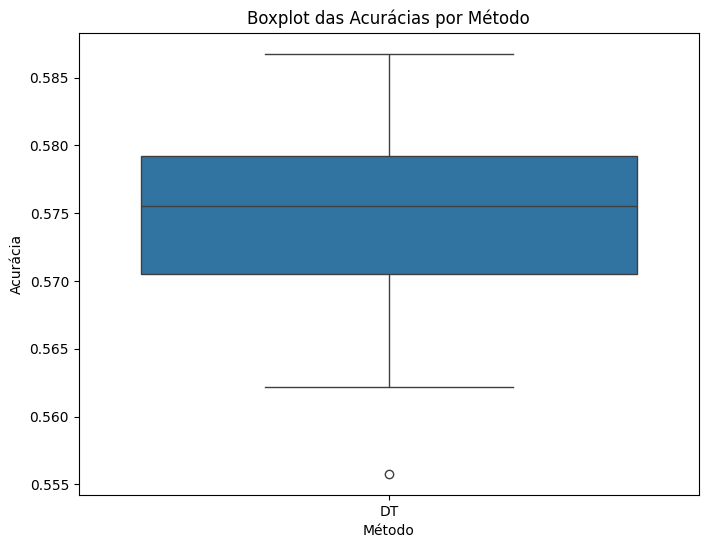

In [71]:
df_long = pd.DataFrame([
    {'Método': metodo, 'Acurácia': acc}
    for metodo, scores in results.items()
    for acc in scores
])

plt.figure(figsize=(8,6))
sns.boxplot(data=df_long, x='Método', y='Acurácia')
plt.title("Boxplot das Acurácias por Método")
plt.show()

In [72]:
metodos = list(results.keys())
n = len(metodos)
matriz = pd.DataFrame("", index=metodos, columns=metodos)

for i in range(n):
    for j in range(n):
        if i == j:
            continue
        scores1 = results[metodos[i]]
        scores2 = results[metodos[j]]
        if i < j:
            # Triângulo superior: t pareado
            stat, p = t_corrigido_nadeau_bengio(scores1, scores2, X, 10)
        else:
            # Triângulo inferior: Wilcoxon
            stat, p = stats.wilcoxon(scores1, scores2)
        # Se p < 0.001, exibe 0.001
        p_show = 0.001 if p < 0.001 else p
        txt = f"**{p_show:.3f}**" if p < 0.05 else f"{p_show:.3f}"
        matriz.iloc[i, j] = txt

print("\nMatriz de Testes de Hipóteses (p-valores):")
display(matriz)


Matriz de Testes de Hipóteses (p-valores):


,DT
DT,
